## 7. Implement boosting and bagging with your choice of base models and explain all the steps 20

The text below can be added to the report md file:

Bagging (Decision Tree)

Bagging trains many decision trees on different bootstrap samples of the training data. Each tree learns independently, which reduces variance and prevents overfitting. During prediction, each tree casts a vote and the majority class becomes the final output (majority voting). Features can also be randomly sampled, increasing model diversity. The result is a stable, low-variance ensemble that often generalizes better than a single decision tree.

Bagging (SVM)

Bagging SVM trains several SVM classifiers on randomly sampled subsets of the data to reduce variance and improve robustness. Each SVM learns slightly different decision boundaries due to sampling variability. Final predictions are produced through majority voting across all ensemble members. This method helps SVMs generalize better when datasets are noisy. The ensemble provides more stable predictions than a single SVM model.

AdaBoost (Decision Tree)

AdaBoost trains many weak learners in sequence, usually decision stumps (depth-1 decision trees). After each iteration, incorrectly classified samples receive higher weights so the next learner focuses on hard examples. Predictions from each tree are combined using weighted voting, where more accurate learners get higher influence. This sequential focusing greatly reduces bias and improves performance on structured datasets. The final model is a strong classifier made from many weak contributors.

XGBoost

XGBoost builds boosted trees one at a time, minimizing a regularized objective function to combat overfitting. Each new tree learns to correct the residual errors made by previous trees. Gradient boosting and second-order optimization (Hessian-based) make the learning highly efficient. XGBoost also uses subsampling and column sampling to reduce variance and improve generalization. The final ensemble is powerful, fast, and often among the top-performing algorithms in tabular ML.

We have implemented two ensemble learning methods, **Bagging** and **Boosting**.\
The **Bagging model** employs a `RandomForestClassifier` as its base estimator within a `BaggingClassifier`, where multiple decision trees are trained independently on random subsets of both samples and features.\
This parallel training reduces variance, prevents overfitting and improves model stability.\
The **Boosting model**, based on `XGBClassifier`, builds an ensemble of weak learners sequentially, where each new tree focuses on correcting the misclassifications made by previous ones.\
This reduced bias and improves predictive performance.

**Modified pipeline**\
The data is first split into training and testing sets using stratified sampling to preserve class distribution. Missing values are handled using a `SimpleImputer` with a median strategy.\
Next, a **`GridSearchCV`** is applied for hyperparameter tuning, testing combinations of parameters like the number of estimators, tree depth, learning rate, and subsampling ratios over multiple cross-validation folds.\
Finally, the best-performing model is refit on the training set and evaluated on the test data using accuracy metrics.\
Although computationally intensive, this approach provides a reliable comparison between Bagging and Boosting techniques.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

In [ ]:
### MODIFIED PIPELINE WITH BOOSTING AND BAGGING MODELS ###
df_my_train_data = pd.read_csv("./student-graduation/processed/train.csv")
df_my_test_data = pd.read_csv("./student-graduation/processed/test.csv")

# df_head = df_my_train_data.head(4000)
#df = df_head.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_train = df_my_train_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
le = LabelEncoder()
df_train['Target'] = le.fit_transform(df_train['Target'])
df_test = df_my_test_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_test['Target'] = le.fit_transform(df_test['Target'])

def get_model_and_params(model_type):
    model_type = str(model_type).strip().lower()

    if model_type == "random_forest":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
        print('model = random_forest')
    elif model_type == "svm":
        model = SVC(random_state=42)
        param_grid = {
            'model__C': [ 10.5, 11, 11.2, 10.8, 11.5],
            'model__kernel': ['linear','rbf','poly', 'sigmoid'],
            'model__gamma': ['scale', 'auto']
        }
        print('model = svm')
    elif model_type in ("neural_net", "mlp"):
        model = MLPClassifier(random_state=42, max_iter=1000, validation_fraction=0.20,n_iter_no_change=20,early_stopping=True, solver='adam',     )
        param_grid = {
            'model__hidden_layer_sizes': [(64,), (128,128), (256)],
            'model__alpha': [1e-4, 1e-3, 1e-2],
            'model__learning_rate_init': [1e-3, 1e-2],
            'model__activation': ['relu', 'tanh']
        }
        print('model = neural_net')
    elif model_type in ("logistic", "logreg", "logistic_regression"):
        model = LogisticRegression(max_iter=2000)
        # Bruk liste av grids for å unngå inkompatible kombinasjoner av solver/penalty
        param_grid = [
            {   # LBFGS: bare L2
                'model__solver': ['lbfgs'],
                'model__penalty': ['l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # liblinear: L1/L2, ovr
                'model__solver': ['liblinear'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # saga: L1/L2, skalerer godt på større datasett
                'model__solver': ['saga'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            }
        ]
    elif model_type == "dt":
        model = DecisionTreeClassifier(random_state=42)
        param_grid = {
            'model__min_samples_leaf': [10, 20, 30],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
            'model__min_weight_fraction_leaf' :[0.0],
            "model__max_features": [None, "sqrt", "log2"],
            # "model__max_leaf_nodes": [63, 127],
            'model__min_samples_split':[2, 5, 7, 10],
            # splitter-strategi
            "model__splitter": ["best", "random"],
            # kostnad-kompleksitets-beskjæring
            "model__ccp_alpha": [0.0, 1e-3,],
            # håndter ev. ubalanse
            "model__class_weight": [None, "balanced"],
            'model__criterion': ['gini', 'entropy', 'log_loss'],
            'model__max_depth': [5, 10, 12, 15, 18],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
        }
        print("model = decision_tree")
    elif model_type in ("nb", "naive_bayes", "gaussian_nb"):
        model = GaussianNB()
        param_grid = {}  # har egentlig ingen viktige hyperparametre å tune
        print("model = gaussian_nb")
    
    # ---------------------------------------------------------
    # BAGGING MODELS
    # ---------------------------------------------------------
    elif model_type == "bagging_dt":
        base = DecisionTreeClassifier(random_state=42)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [50, 100, 200],
            "model__max_samples": [0.6, 0.8, 1.0],
            "model__max_features": [0.6, 0.8, 1.0]
        }
        print("model = bagging_dt")

    elif model_type == "bagging_svm":
        base = SVC(probability=True, random_state=42)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 30],
            "model__max_samples": [0.6, 0.8],
            "model__max_features": [0.6, 0.8]
        }
        print("model = bagging_svm")

    elif model_type == "bagging_lr":
        base = LogisticRegression(max_iter=2000)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 20, 30],
            "model__max_samples": [0.5, 0.7, 1.0],
        }
        print("model = bagging_lr")


    # ---------------------------------------------------------
    # BOOSTING MODELS
    # ---------------------------------------------------------
    elif model_type == "adaboost_dt":
        base = DecisionTreeClassifier(max_depth=1)
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.5, 1.0, 1.5]
        }
        print("model = adaboost_dt")

    elif model_type == "adaboost_lr":
        base = LogisticRegression(max_iter=2000)
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [20, 50, 80],
            "model__learning_rate": [0.1, 0.5, 1.0]
        }
        print("model = adaboost_lr")


    elif model_type == "gradientboosting":
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1, 0.2],
            "model__max_depth": [2, 3, 4]
        }
        print("model = gradientboosting")


    elif model_type == "xgboost":
        model = XGBClassifier(
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        )
        param_grid = {
            "model__n_estimators": [200, 300],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [4, 6, 8],
            "model__subsample": [0.6, 0.8, 1.0],
        }
        print("model = xgboost")

    else:
        raise ValueError("Ukjent modelltype")
    return model, param_grid

def run_pipeline(data_train: pd.DataFrame, data_test: pd.DataFrame, target_column: str, model_type: str):
    if target_column not in data_train.columns:
        raise ValueError(f"Målkolonnen '{target_column}' finnes ikke i data.")

    X_train = data_train.drop(columns=[target_column])
    y_train = data_train[target_column]

    X_test = data_test.drop(columns=[target_column])
    y_test = data_test[target_column]


    # Konservativ CV basert på minste klassefrekvens
    min_class_count = pd.Series(y_train).value_counts().min()
    cv = int(min(5, max(2, min_class_count)))

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42, stratify=y
    # )

    model, param_grid = get_model_and_params(model_type)

    
    if isinstance(model, MultinomialNB):
        steps = [
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('model', model)
        ]
    else:
        steps = [
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=False) if scipy.sparse.issparse(X_train) else StandardScaler()),
            ('model', model)
        ]
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            refit=True,
            error_score='raise'
        )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("✅ Beste parametere:", grid_search.best_params_)
    print("📊 Test accuracy:", acc)
    return best_model

def plot_conf_matrix(model, df_test, target_col='Target', title="Confusion Matrix"):
    X_test = df_test.drop(columns=[target_col])
    y_test = df_test[target_col]

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

<h3 style="color:yellow"> The code below takes ~5 minutes to run.</h3>

model = bagging_dt
✅ Beste parametere: {'model__max_features': 0.6, 'model__max_samples': 1.0, 'model__n_estimators': 200}
📊 Test accuracy: 0.7766726943942134


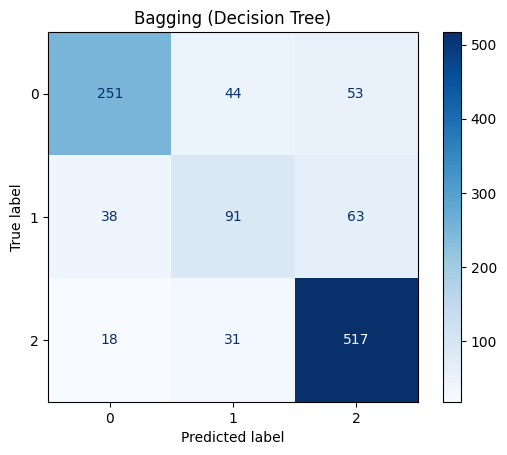

model = bagging_svm
✅ Beste parametere: {'model__max_features': 0.8, 'model__max_samples': 0.8, 'model__n_estimators': 30}
📊 Test accuracy: 0.7531645569620253


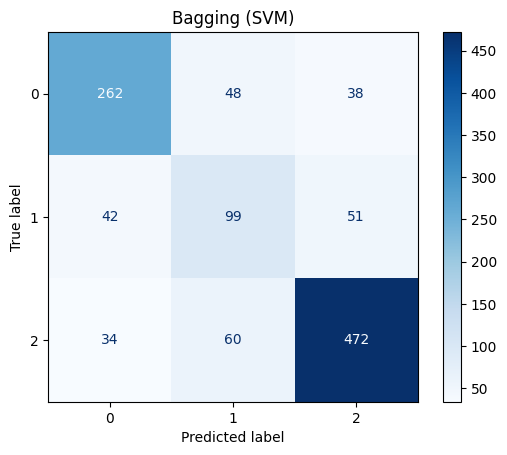

model = adaboost_dt
✅ Beste parametere: {'model__learning_rate': 1.5, 'model__n_estimators': 200}
📊 Test accuracy: 0.72875226039783


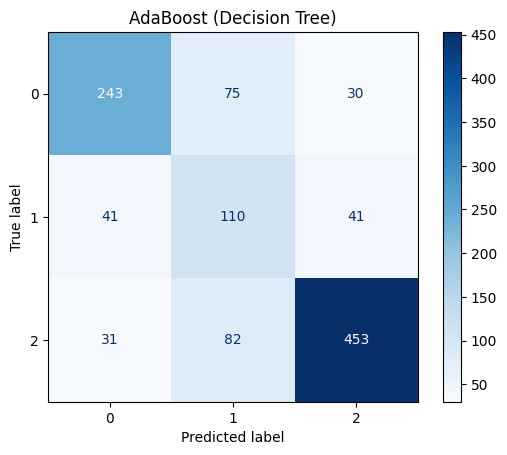

model = xgboost
✅ Beste parametere: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 300, 'model__subsample': 0.6}
📊 Test accuracy: 0.7694394213381555


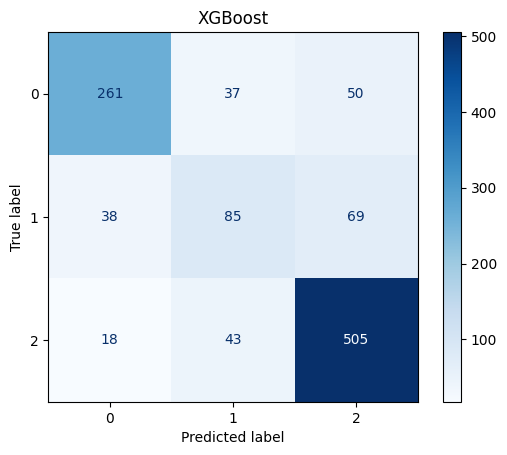

In [70]:
# Bagging (DT)
model_bagging_dt = run_pipeline(df_train, df_test, "Target", model_type="bagging_dt")
plot_conf_matrix(model_bagging_dt, df_test, title="Bagging (Decision Tree)")

# Bagging (SVM)
model_bagging_svm = run_pipeline(df_train, df_test, "Target", model_type="bagging_svm")
plot_conf_matrix(model_bagging_svm, df_test, title="Bagging (SVM)")

# AdaBoost + Decision Tree
model_adaboost_dt = run_pipeline(df_train, df_test, "Target", model_type="adaboost_dt")
plot_conf_matrix(model_adaboost_dt, df_test, title="AdaBoost (Decision Tree)")

# XGBoost
model_xgboost = run_pipeline(df_train, df_test, "Target", model_type="xgboost")
plot_conf_matrix(model_xgboost, df_test, title="XGBoost")

In [77]:
# If mismatches appear, fix them (drop or add missing columns).
def check_column_alignment(df_train, df_test):
    """
    Ensure feature-mismatch detection which prevents runtime errors during prediction
    """
    train_cols = set(df_train.drop(columns=['Target']).columns)
    test_cols  = set(df_test.drop(columns=['Target']).columns)

    print("Columns only in TRAIN:", train_cols - test_cols)
    print("Columns only in TEST :", test_cols - train_cols)

# Check class distribution + baseline accuracy
def show_class_distribution(y_train, y_test):
    """
    Shows class imbalance
    Shows a baseline model = always predict the majority class
    Helps compare models to a very simple rule
    """
    print("Class distribution (train):")
    print(pd.Series(y_train).value_counts(normalize=True))
    
    major = pd.Series(y_test).value_counts().idxmax()
    print("\nMajority baseline accuracy:", (y_test == major).mean())

# Baseline Logistic Regression with “balanced” class weights
def run_logreg_baseline(df_train, df_test):
    """
    Creates a simple baseline model
    Uses balanced accuracy, helpful in class imbalance
    Useful for comparing advanced models (Boosting, Bagging, SVM, RF, etc.)
    """
    X_train = df_train.drop(columns=['Target'])
    y_train = df_train['Target']
    
    X_test = df_test.drop(columns=['Target'])
    y_test = df_test['Target']

    baseline = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", multi_class="ovr"))
    ])
    baseline.fit(X_train, y_train)
    y_pred = baseline.predict(X_test)

    print("Baseline balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

# Correlation analysis
def show_high_correlations(df, threshold=0.7):
    """
    Detect redundant features
    Identify multicollinearity
    Help decide whether to drop or combine features
    """
    corr = df.corr()
    mask = (corr.abs() > threshold) & (corr.abs() < 1)
    filtered = corr.where(mask).stack().reset_index()
    filtered.columns = ["feature_1", "feature_2", "correlation"]
    filtered = filtered.reindex(filtered["correlation"].abs().sort_values(ascending=False).index)

    pd.set_option("display.max_rows", filtered.shape[0] + 1)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", None)

    print(filtered.to_string(index=False))

check_column_alignment(df_train, df_test)
print("---")
show_class_distribution(df_train['Target'], df_test['Target'])
print("---")
run_logreg_baseline(df_train, df_test)
print("---")
show_high_correlations(df_train.drop(columns=['Target']))

Columns only in TRAIN: set()
Columns only in TEST : set()
---
Class distribution (train):
Target
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64

Majority baseline accuracy: 0.5117540687160941
---
Baseline balanced accuracy: 0.7013637155950883
---
                             feature_1                              feature_2  correlation
   Curricular units 1st sem (credited)    Curricular units 2nd sem (credited)     0.948786
   Curricular units 2nd sem (credited)    Curricular units 1st sem (credited)     0.948786
             Previous qualification_14                    Application mode_15     0.938656
                   Application mode_15              Previous qualification_14     0.938656
   Curricular units 2nd sem (enrolled)    Curricular units 1st sem (enrolled)     0.936763
   Curricular units 1st sem (enrolled)    Curricular units 2nd sem (enrolled)     0.936763
   Curricular units 1st sem (approved)    Curricular units 2nd sem (approved)     0.8883

c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


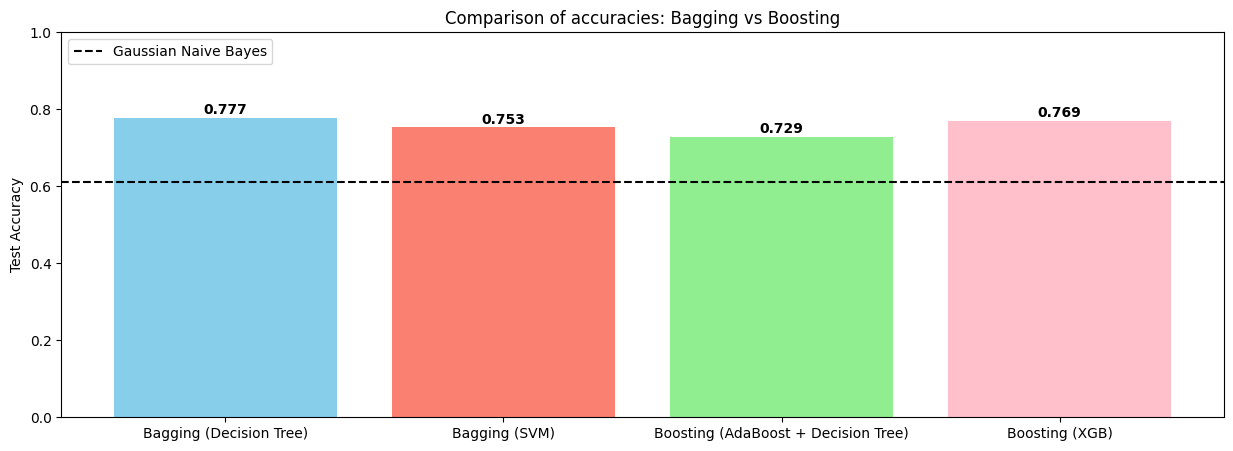

In [ ]:
import matplotlib.pyplot as plt

# Store accuracies manually from pipeline
acc_bagging_dt = 0.7766726943942134 # replace as needed
acc_bagging_svm = 0.7531645569620253 # replace as needed
acc_adaboost_dt = 0.72875226039783 # replace as needed
acc_xgboost = 0.7694394213381555 # replace as needed
gaussian_nb_orginal_accurracy = 0.6103074141048824 # based on the value found in pipeline.ipynb, replace as needed

models = ['Bagging (Decision Tree)', 'Bagging (SVM)', 'Boosting (AdaBoost + Decision Tree)', 'Boosting (XGB)']
accuracies = [acc_bagging_dt, acc_bagging_svm, acc_adaboost_dt, acc_xgboost]

plt.figure(figsize=(15,5))
plt.bar(models, accuracies, color=['skyblue', 'salmon', 'lightgreen', 'pink'])
plt.axhline(y=gaussian_nb_orginal_accurracy, color='black', linestyle='--', label="Gaussian Naive Bayes")
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Comparison of accuracies: Bagging vs Boosting")
plt.legend(loc="upper left")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

In [98]:
### Evaluation suite giving full reports, confusion matrix, ROC curves, and feature importances ###
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)
import numpy as np


def evaluate_model(model, df_test, target_col="Target"):
    print("=== MODEL EVALUATION ===")
    
    X_test = df_test.drop(columns=[target_col])
    y_test = df_test[target_col]
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    
    # # Confusion Matrix
    # print("\n--- Confusion Matrix ---")
    # cm = confusion_matrix(y_test, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap=plt.cm.Blues)
    # plt.show()
    
    # ROC/AUC (OvR if multiclass)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        
        try:
            if y_proba.shape[1] == 2:  # binary
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                auc_score = auc(fpr, tpr)
                print(f"\nROC-AUC: {auc_score:.4f}")
                
                plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
                plt.plot([0,1], [0,1], linestyle='--')
                plt.title("ROC Curve")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend()
                plt.show()
            else:  # multiclass
                auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")
                print(f"\nMulticlass ROC-AUC (OvR): {auc_score:.4f}")
        except:
            print("ROC could not be computed.")
    
    # Feature Importance (tree models)
    if hasattr(model['model'], "feature_importances_"):
        print("\n--- Feature Importances ---")
        importances = model['model'].feature_importances_
        cols = X_test.columns
        for col, imp in sorted(zip(cols, importances), key=lambda x: -x[1]):
            print(f"{col}: {imp:.4f}")

In [100]:
print("Bagging (Decision Tree)")
evaluate_model(model_bagging_dt, df_test)
print("Bagging (SVM)")
evaluate_model(model_bagging_svm, df_test)
print("AdaBoost (Decision Tree)")
evaluate_model(model_adaboost_dt, df_test)
print("XGBoost")
evaluate_model(model_xgboost, df_test)

Bagging (Decision Tree)
=== MODEL EVALUATION ===
Accuracy: 0.7767
Balanced Accuracy: 0.7029

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       348
           1       0.55      0.47      0.51       192
           2       0.82      0.91      0.86       566

    accuracy                           0.78      1106
   macro avg       0.73      0.70      0.71      1106
weighted avg       0.77      0.78      0.77      1106


Multiclass ROC-AUC (OvR): 0.8793
Bagging (SVM)
=== MODEL EVALUATION ===
Accuracy: 0.7532
Balanced Accuracy: 0.7008

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       348
           1       0.48      0.52      0.50       192
           2       0.84      0.83      0.84       566

    accuracy                           0.75      1106
   macro avg       0.70      0.70      0.70      1106
weighted avg       0.76

## Interpration

We interpret the evaluation metrics for multiclass models on the three outcome classes:

0 – Dropout

1 – Enrolled

2 – Graduate

---
1. Accuracy

Definition:
Percentage of all predictions that were correct.

Interpretation:
Accuracy ranges from 0.7288 → 0.7767 across models.
This means the best model (Bagging DT) correctly predicts ~78% of students.
However, accuracy can be misleading because the classes are unbalanced (many students are "graduates").

---
2. Balanced Accuracy

Definition:
Mean recall across all classes, giving each class equal weight.

Formula: $Balanced Acc =\frac{1}{3}​(R0​+R1​+R2​)$

Interpretation:
Balanced accuracy is ~0.69 to ~0.70, lower than raw accuracy.
This indicates:

The models predict class 2 (Graduate) well

They struggle with class 1 (Enrolled)

Balanced accuracy exposes this weakness

Bagging DT again performs best with 0.7029.

---
3. Precision, Recall, F1-score (from Classification Report)

These are given for each class:

Precision

Of all predicted class X, how many were correct?

High for class 2 (0.81–0.86) → very reliable when predicting graduate.

Low for class 1 (0.41–0.55) → many false positives.

Recall

Of all true class X, how many were found?

High for graduates (0.80–0.91)

Low for enrolled (0.44–0.57) → models miss many enrolled students.

F1-score

Harmonic mean of precision & recall.
Shows same pattern: strong on class 2, weak on class 1.

---
4. ROC-AUC (multiclass OvR)

Definition:
Measures how well the model separates classes.
Ranges from 0.5 (random) to 1 (perfect).

Interpretation:
Values range 0.84–0.88, fairly strong.
XGBoost and Bagging DT show the best class separation.

---
5. Feature Importances (for tree models)

Definition:
How much each feature reduces impurity or contributes to predicting the target.

Interpretation:
Across models, the most important predictors are:

Curricular units (approved) → academic performance

Tuition fees up to date → financial stability

Enrollment age

Grades

Debtor status

Scholarship holder

Many one-hot encoded categorical features have near-zero importance.

---
SUMMARY OF INTERPRETATION

✔ All models do very well at detecting graduates\
✔ All models struggle with the Enrolled class\
✔ Bagging DT and XGBoost are the strongest overall\
✔ ROC-AUC shows the models have good separability\
✔ Academic features dominate importance rankings

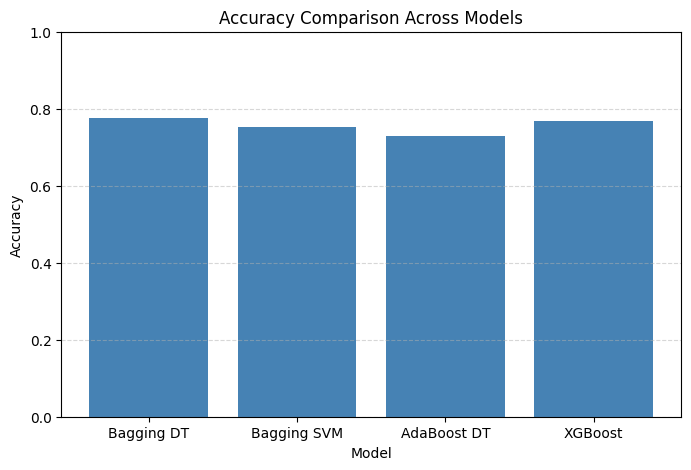

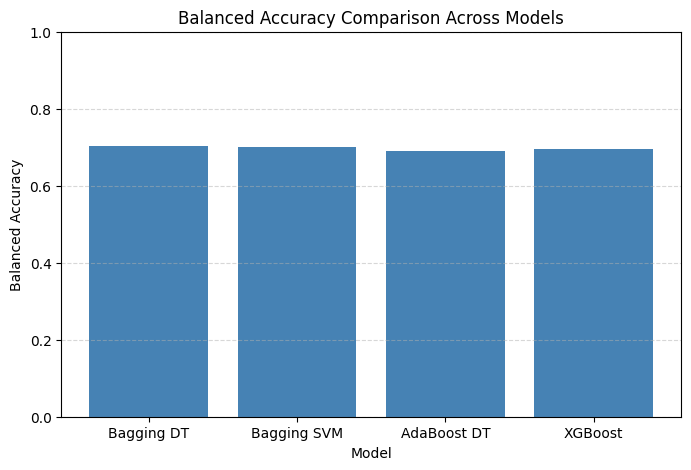

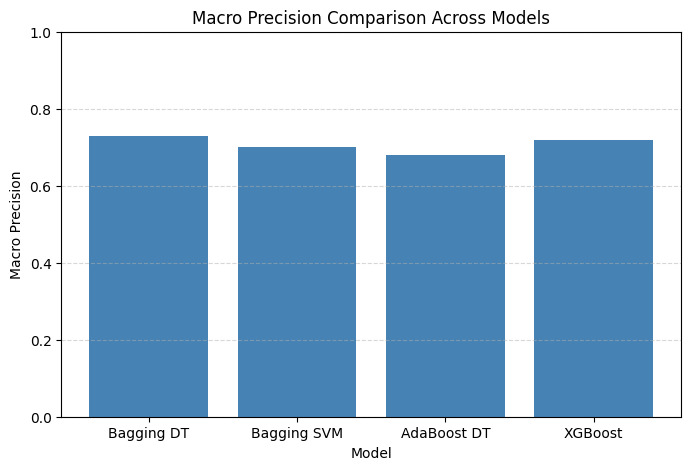

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Store statistics from evaluation
models = ["Bagging DT", "Bagging SVM", "AdaBoost DT", "XGBoost"]

accuracy = [0.7767, 0.7532, 0.7288, 0.7694]
balanced_accuracy = [0.7029, 0.7008, 0.6905, 0.6950]

# Macro precision from reports:
precision_macro = [0.73, 0.70, 0.68, 0.72]

# --------- PLOTTING FUNCTION ----------
def plot_stat(stat_values, stat_name):
    plt.figure(figsize=(8,5))
    plt.bar(models, stat_values, color='steelblue')
    plt.title(f"{stat_name} Comparison Across Models")
    plt.xlabel("Model")
    plt.ylabel(stat_name)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# Create three separate graphs
plot_stat(accuracy, "Accuracy")
plot_stat(balanced_accuracy, "Balanced Accuracy")
plot_stat(precision_macro, "Macro Precision")


In [102]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(model, X_test, y_test, model_name):
    # Binarize labels for OvR ROC
    classes = np.unique(y_test)
    y_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    if not hasattr(model, "predict_proba"):
        print(f"{model_name} does not support predict_proba. Skipping.")
        return
    
    y_proba = model.predict_proba(X_test)

    plt.figure(figsize=(7, 6))

    # Compute ROC per class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title(f"ROC Curve (OvR) - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.4)
    plt.show()

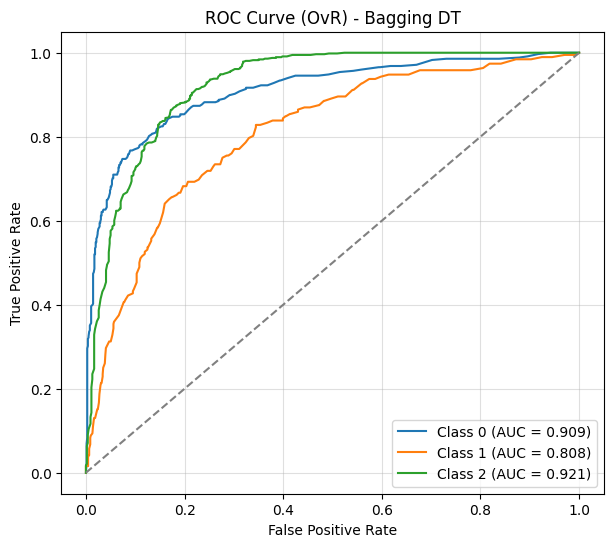

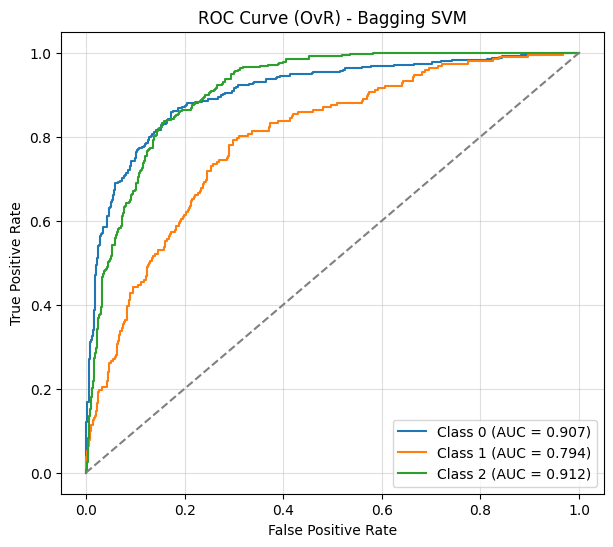

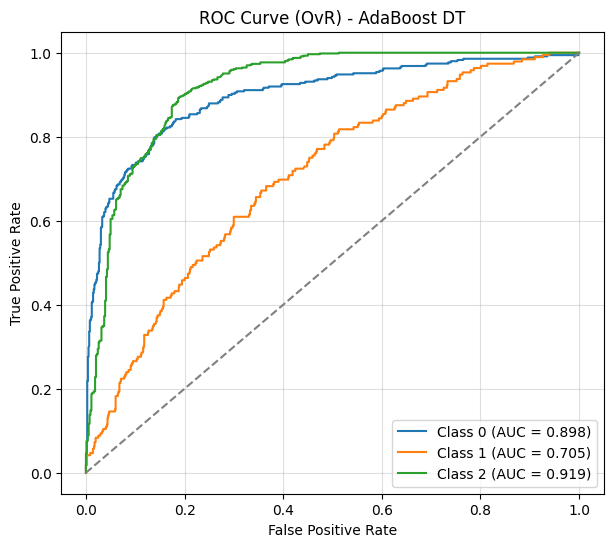

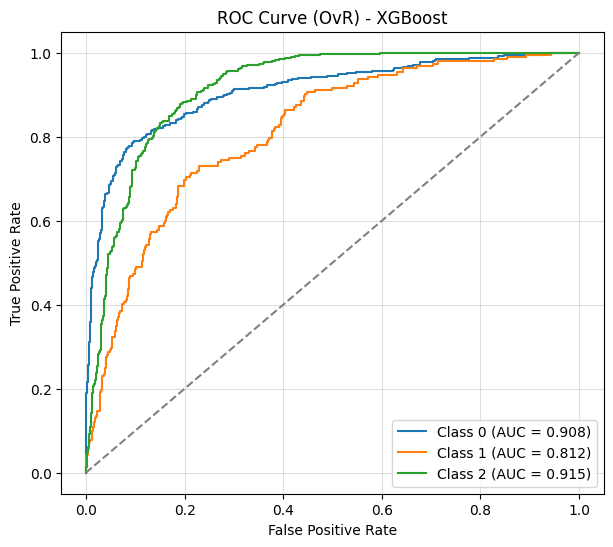

In [103]:
X_test = df_test.drop(columns=["Target"])
y_test = df_test["Target"]

plot_multiclass_roc(model_bagging_dt, X_test, y_test, "Bagging DT")
plot_multiclass_roc(model_bagging_svm, X_test, y_test, "Bagging SVM")
plot_multiclass_roc(model_adaboost_dt, X_test, y_test, "AdaBoost DT")
plot_multiclass_roc(model_xgboost, X_test, y_test, "XGBoost")
